In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

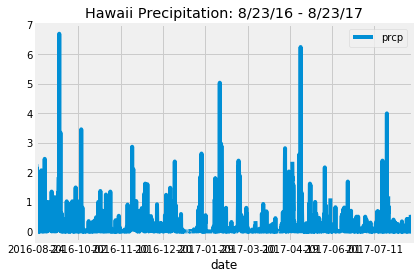

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

lastDate = list(np.ravel(lastDate))[0]

lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')

lastYear = int(dt.datetime.strftime(lastDate, '%Y'))

lastMonth = int(dt.datetime.strftime(lastDate, '%m'))

lastDay = int(dt.datetime.strftime(lastDate, '%d'))

# Calculate the date 1 year ago from the last data point in the database
yearBefore = dt.date(lastYear, lastMonth, lastDay) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
rainData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
rainDF = pd.DataFrame(rainData)
rainDF = rainDF.set_index('date')

# Sort the dataframe by date
rainDF = rainDF.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rainDF.plot(title="Hawaii Precipitation: 8/23/16 - 8/23/17")


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainDF.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stationsCount = session.query(Station).count()
print(f"Number of Stations: {stationsCount}")

Number of Stations: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
rowsperStation = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
rowsperStation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mostActiveStationID = rowsperStation[0][0]

mostActiveStationName = (session.query(Station.name)
                      .filter_by(station = mostActiveStationID))
mostActiveStationName = mostActiveStationName[0][0]
print(f"The most active station is {mostActiveStationName} and its station ID is ({mostActiveStationID}).")

#querying for max temperature
maxTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == mostActiveStationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
maxTemp = maxTemp[0]
print(f"The highest temperature recorded at {mostActiveStationName} is {maxTemp} Degree Farenheit.")

#querying for min temperature
minTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == mostActiveStationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
minTemp = minTemp[0]
print(f"The lowest temperature recorded at {mostActiveStationName} is {minTemp} Degree Farenheit.")

#querying for average temperature
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == mostActiveStationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded at {mostActiveStationName} is {avgTemp} Degree Farenheit.")

The most active station is WAIHEE 837.5, HI US and its station ID is (USC00519281).
The highest temperature recorded at WAIHEE 837.5, HI US is 85.0 Degree Farenheit.
The lowest temperature recorded at WAIHEE 837.5, HI US is 54.0 Degree Farenheit.
The average temperature recorded at WAIHEE 837.5, HI US is 71.7 Degree Farenheit.


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatureData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == mostActiveStationID)
                   .order_by(Measurement.date)
                   .all())

#convert query object to data frame
temperatureDF = pd.DataFrame(temperatureData)
temperatureDF = temperatureDF.set_index('date')

#sory by date
temperatureDF = temperatureDF.sort_index(ascending=True)

#histogram plot with pandas
temperatureDF.plot(kind='hist', bins=12)


In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = '2019-04-08 to \n 2019-04-19'
tripStarted = '2017-01-15'
tripEnded = '2017-01-30'

#calculate the tmin, tavg, and tmax 
tripTemps = calc_temps(tripStarted,tripEnded)

minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

print(f"Min temperature during trip: {minTripTemp} degree Fahrenheit")
print(f"Average temperature during trip: {avgTripTemp} degree Fahrenheit")
print(f"Max temperature during trip: {maxTripTemp} degree Fahrenheit")



In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'orangered', alpha=.6)
plt.ylim(0, 90)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
data = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*data)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStarted)
                   .filter(Measurement.date <= tripEnded)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
stationRainDF = pd.DataFrame(np.array(stationRain))
#rename columns
stationRainDF = stationRainDF.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainDF


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startDate = "2019-12-15"
endDate = "2019-12-30"

startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1

# Use the start and end date to create a range of dates
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')


# Stip off the year and save a list of %m-%d strings
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]


#calculate normals for each date
tripNormals = [daily_normals(date) for date in dateList]

tripNormals

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

tripNormals = [np.array(normal[0]) for normal in tripNormals]

normalsDF = pd.DataFrame(tripNormals)
#add date column
normalsDF["Date"] = dateList
#set index and rename columns
normalsDF = normalsDF.set_index("Date")
normalsDF = normalsDF.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsDF

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
normalsDF.plot.area(stacked=False, alpha=.333)